<h1>Predict True or False if the keypoints makes a human figure</h1>

<h3>Imports</h3>

In [54]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torchmetrics
from sklearn.model_selection import train_test_split

<h3>Data Loading</h3>

In [2]:
human_keypoints = pd.read_csv("./human_keypoints_dataset.csv")
human_keypoints.head()

,label,head_x,head_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,True,240.500559,85.183148,195.716557,156.683877,299.248962,164.531874,187.337512,179.991048,306.974952,...,288.583761,311.323783,216.606421,399.107787,296.439782,397.644581,199.204957,493.226067,306.906930,497.484215
1,False,201.841402,124.894075,178.729435,131.932138,291.446801,207.304203,229.382600,198.435965,246.279427,...,286.109122,247.173054,137.740705,385.958958,267.464251,443.406363,257.896089,458.535632,261.136046,439.355304
2,True,259.978617,78.683620,200.490441,167.050014,320.194094,135.924078,178.438036,205.578941,319.493074,...,280.596345,290.100207,207.328399,409.183797,305.853671,407.266601,214.605122,504.378187,311.688375,498.851795
3,False,258.375514,155.753934,282.675073,212.995371,300.949045,232.212687,198.877240,353.738290,313.514863,...,264.883632,309.761761,107.352101,438.606151,318.370386,345.648371,250.241387,599.670955,274.235694,493.347026
4,True,244.427543,77.570950,202.441213,155.809494,301.347111,140.021596,178.519725,194.275375,312.954924,...,290.239627,289.878072,220.442557,407.704236,295.792189,396.938297,218.037550,503.256533,313.782626,509.867995


<h3>Data Visualization</h3>

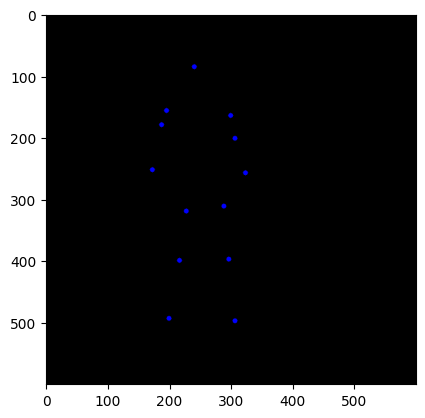

In [6]:
# visualize 2 samples from the dataset

# make a blank image
image_true = np.zeros((600, 600, 3), dtype = "uint8")
image_false = np.zeros((600, 600, 3), dtype = "uint8")

# function to draw keypoints
def draw_keypoints(image, keypoints):
    for i in range(0, len(keypoints), 2):
        x, y = int(keypoints[i]), int(keypoints[i + 1])
        cv2.circle(image, (x, y), 4, (0, 0, 255), -1)

# show a true label for the keypoints being a human
true_keypoints = human_keypoints.iloc[0][1:].values
draw_keypoints(image_true, true_keypoints)
plt.imshow(image_true)
plt.show()

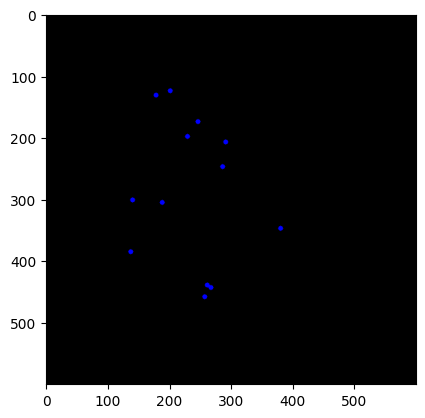

In [7]:
# show a false label for the keypoints NOT being a human
false_keypoints = human_keypoints.iloc[1][1:].values
draw_keypoints(image_false, false_keypoints)
plt.imshow(image_false)
plt.show()

<h3>Data Preprocessing</h3>

In [12]:
# check for NaN values
print(f"Number of Null values in dataset is: {human_keypoints.isna().sum().sum()}")

Number of Null values in dataset is: 0


In [49]:
# split features from target
X = human_keypoints.drop('label', axis = 1)
y = human_keypoints['label']

# convert data into tensors
X_tensor, y_tensor = torch.tensor(X.values, dtype = torch.float32), torch.tensor(y.values, dtype = torch.float32).view(-1, 1)

# split the data in train and validation sets
X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = train_test_split(X_tensor, y_tensor, test_size = 0.2, random_state = 42)

# datasets 
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# dataloaders
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = True)

<h3>Model training, prediction and validation</h3>

In [27]:
# define number of features
n_features = X.shape[1]

In [28]:
model = nn.Sequential(
    nn.Linear(n_features, 10),
    nn.ReLU(),
    nn.Linear(10, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
)
print(model)

Sequential(
  (0): Linear(in_features=26, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
  (5): Sigmoid()
)


In [52]:
# loss function
criterion = nn.BCELoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, label in train_loader:
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        loss = criterion(outputs, label)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch + 1} / {num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1 / 10, Loss: 0.0751
Epoch 2 / 10, Loss: 0.0213
Epoch 3 / 10, Loss: 0.0196
Epoch 4 / 10, Loss: 0.0194
Epoch 5 / 10, Loss: 0.0188
Epoch 6 / 10, Loss: 0.0184
Epoch 7 / 10, Loss: 0.0164
Epoch 8 / 10, Loss: 0.0154
Epoch 9 / 10, Loss: 0.0152
Epoch 10 / 10, Loss: 0.0152


In [62]:
# evaluate the model

model.eval()

metric = torchmetrics.Accuracy(task="binary")

with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features).squeeze()  

        predictions = (outputs > 0.5).float()

        labels = labels.float().squeeze() 

        metric.update(predictions, labels.int())

    acc = metric.compute()

print(f"Accuracy on test data: {acc:.4f}")

Accuracy on test data: 0.7700
